In [2]:
from torchvision import datasets, transforms
from utils.train_utils import get_data, get_model
from utils.options import args_parser
from utils.sampling import iid, noniid, noniid_replace, iid_unbalanced, noniid_unbalanced
import numpy as np
import matplotlib.pyplot as plt
import torch


In [3]:
trans_mnist_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trans_mnist_val = trans_mnist_train
trans_cifar10_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
trans_cifar10_val = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
trans_cifar100_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    ]
)
trans_cifar100_val = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])]
)


In [4]:
def get_dataset(dataset_name: str, dataset_type: str = "test"):
    dataset_name = dataset_name.lower()
    dataset_type = dataset_type.lower()
    train = dataset_type == "train"
    transform = eval(f"trans_{dataset_name}_{'train' if train else 'val'}")
    dataset_class = eval(f"datasets.{dataset_name.upper()}")
    return dataset_class(f"data/{dataset_name}", train=train, download=True, transform=transform)


In [5]:
def parse_dict_users(dataset, dict_users):
    num_classes = len(np.unique(dataset.targets))  # 100
    results = {i: np.array([0] * num_classes, dtype="int64") for i in dict_users.keys()}
    for user_idx, data_idxs in dict_users.items():
        for data_idx in data_idxs:
            label = dataset.targets[data_idx]
            results[user_idx][label] += 1
    return results


In [6]:
def plot(dataset, dict_users, show_label=True, num_users=None, num_classes=None):
    if num_classes == None:
        num_classes = len(np.unique(dataset.targets))
    results = parse_dict_users(dataset, dict_users)
    users = list(results.keys())
    if num_users != None:
        remain_users = sorted(np.random.choice(users, num_users, replace=False))
        for user in users:
            if user in remain_users:
                continue
            results.pop(user)
        users = remain_users

    labels = [f"user {i:2d}" if type(i) == int else i for i in list(results.keys())]
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps["rainbow"](np.linspace(0.1, 0.9, num_classes))

    fig, ax = plt.subplots(figsize=(20, int(1 * len(labels))))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data[:, :num_classes], axis=1).max())
    plt.rc("ytick", labelsize="large")
    for i, (class_idx, color) in enumerate(zip(range(num_classes), category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5, label=f"class {class_idx:2d}", color=color)

        # r, g, b, _ = color
        # text_color = 'white' if r * g * b < 0.5 else 'black'
        text_color = "black"
        if show_label:
            ax.bar_label(rects, label_type="center", color=text_color, fontsize="x-large")
    # ax.legend(ncol=num_classes, bbox_to_anchor=(0, 1), loc="lower left", fontsize="x-large")
    plt.show()
    # return fig, ax



### iid
- class 상관없이 각 user에게 같은 수의 데이터를 랜덤하게 할당 (남는 데이터는 버림)

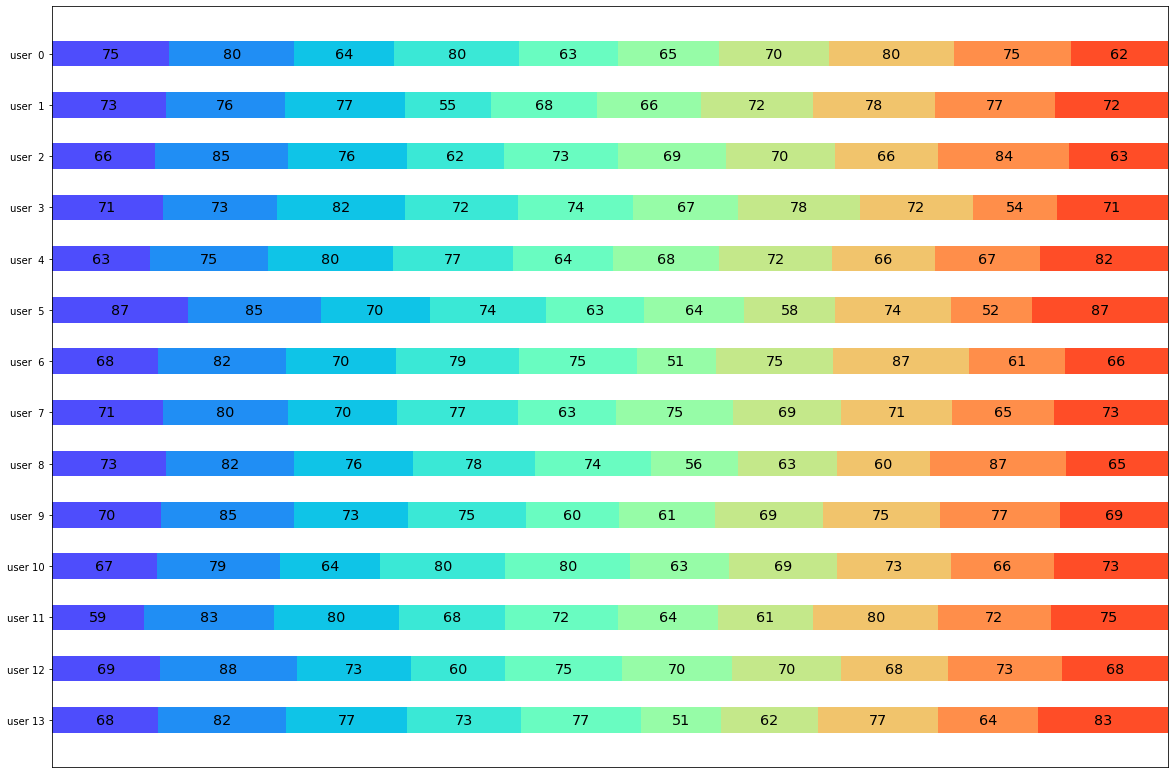

Files already downloaded and verified


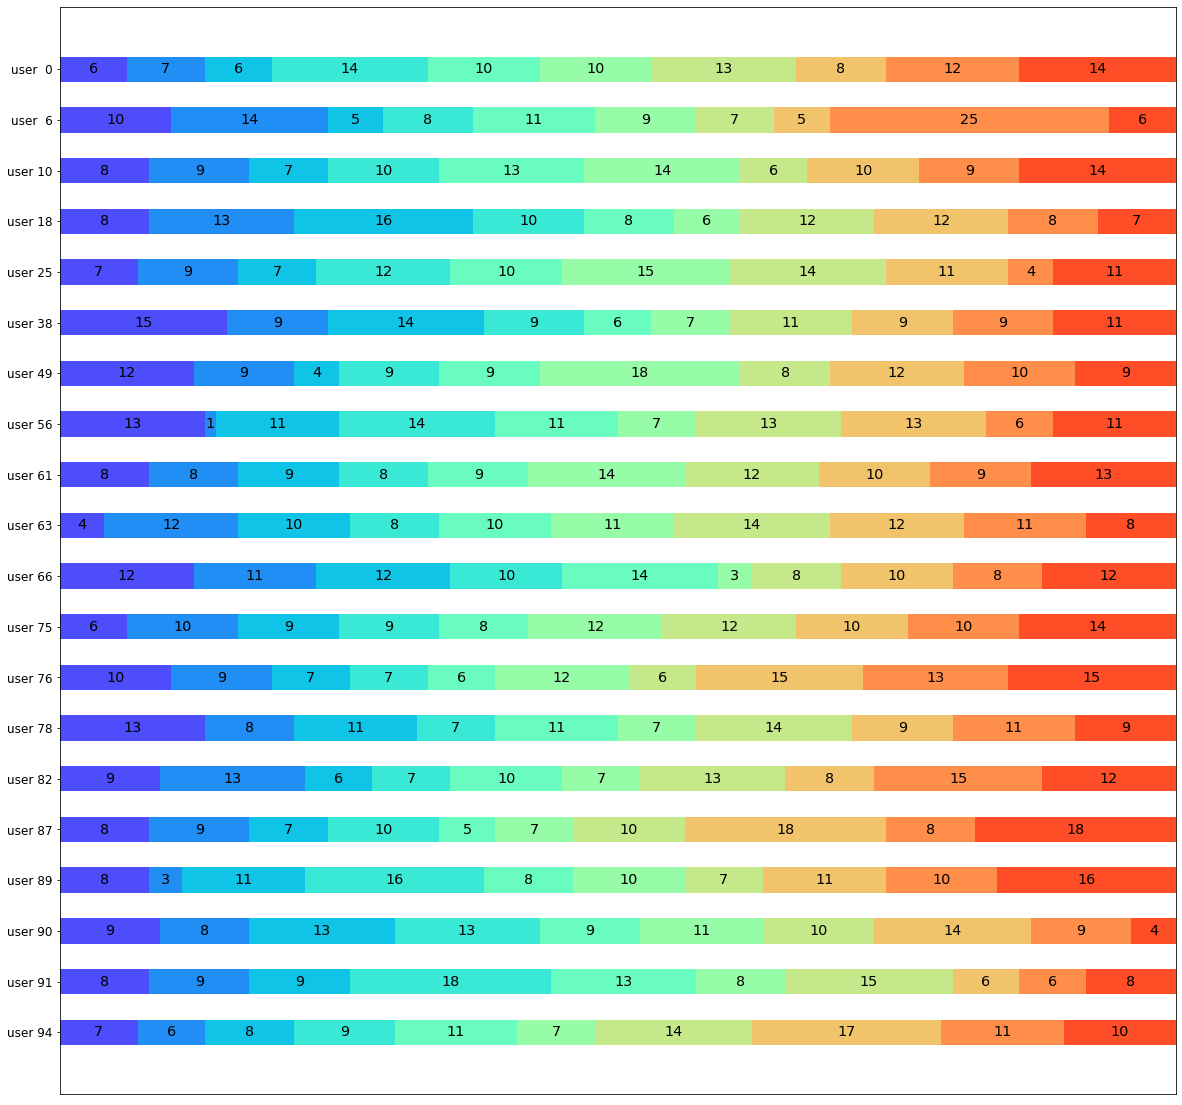

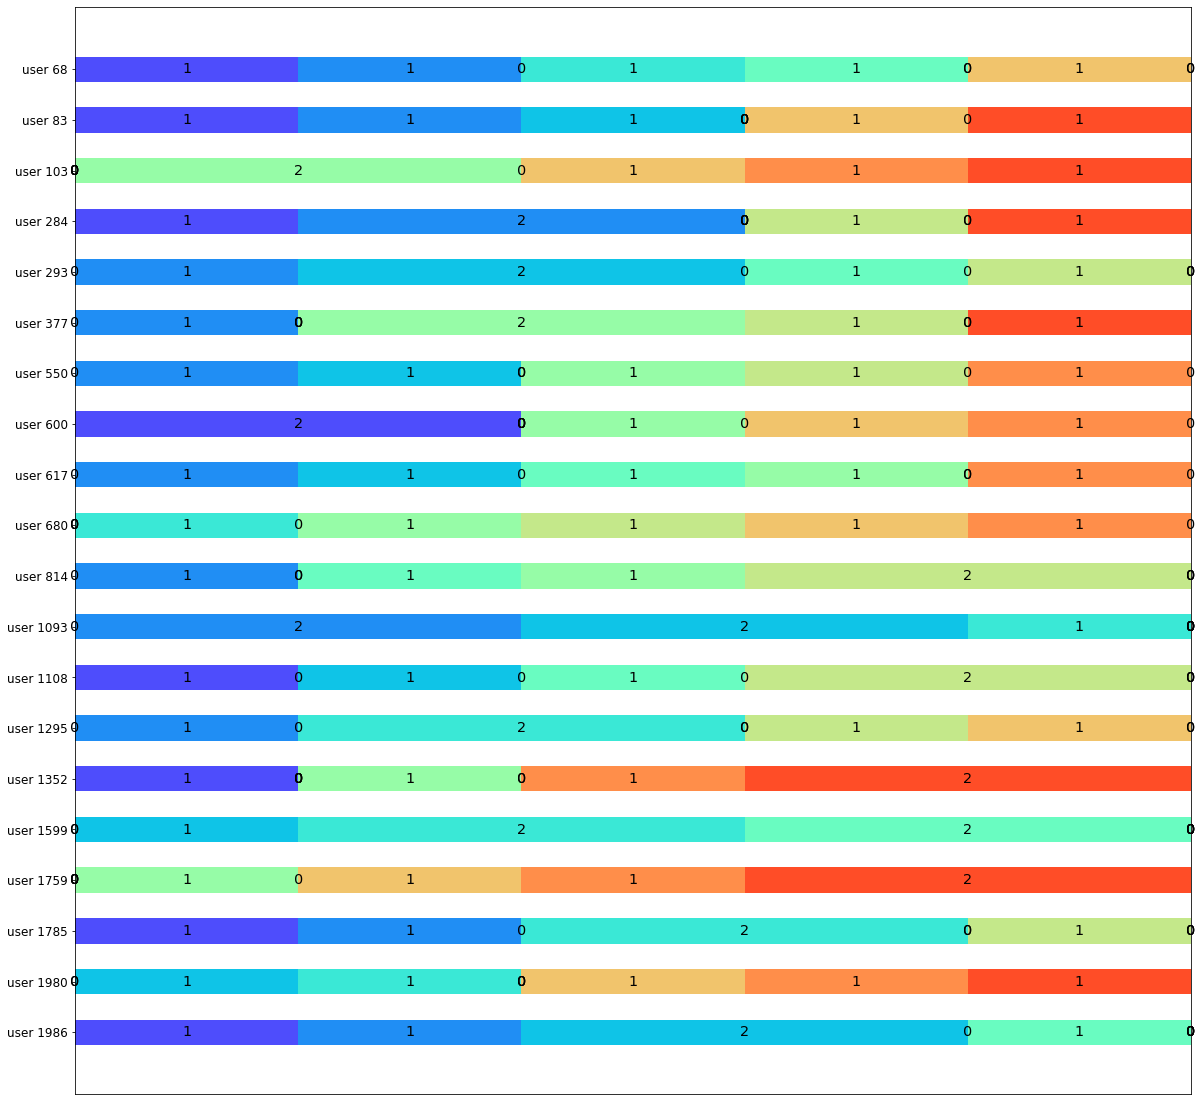

In [7]:
dataset = get_dataset("mnist")
dict_users = iid(dataset, num_users=14, server_data_ratio=0.0)
plot(dataset, dict_users, show_label=True, num_users=None, num_classes=None)

dataset = get_dataset("cifar10")
dict_users = iid(dataset, num_users=100, server_data_ratio=0.0)
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

dict_users = iid(dataset, num_users=2000, server_data_ratio=0.0)
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

### noniid
- iid와 유사하지만, shard 단위로 할당함
- shard의 길이가 길수록, class 불균형 & 데이터 수 불균형 높음 (=> shard가 1이면 iid와 같음)
- shard의 길이 = len(dataset) / (num_users * shard_per_user)

Files already downloaded and verified
len shard = 1.0


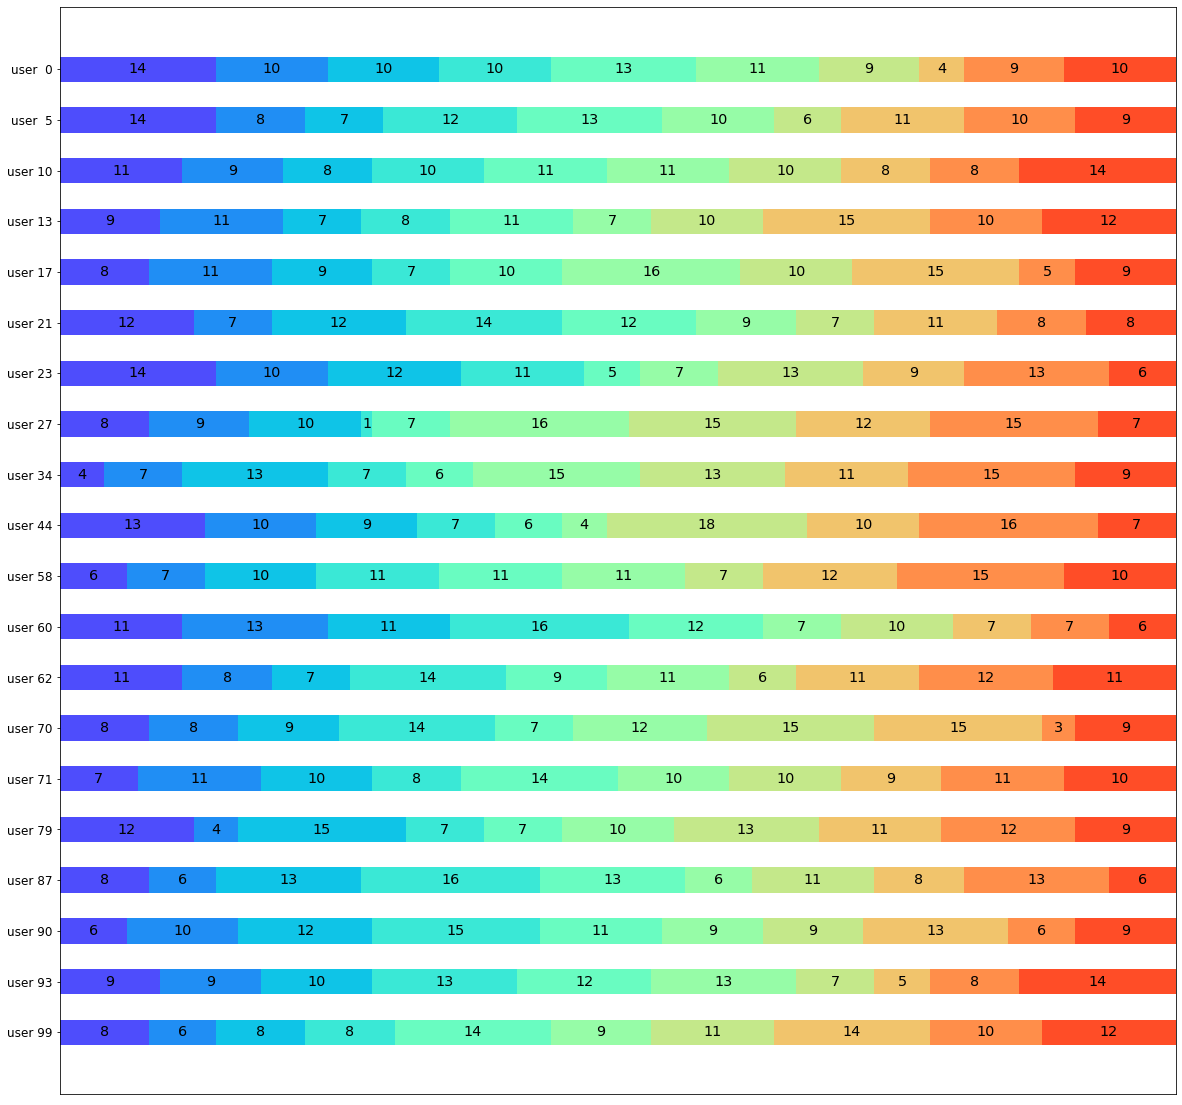

len shard = 1.0


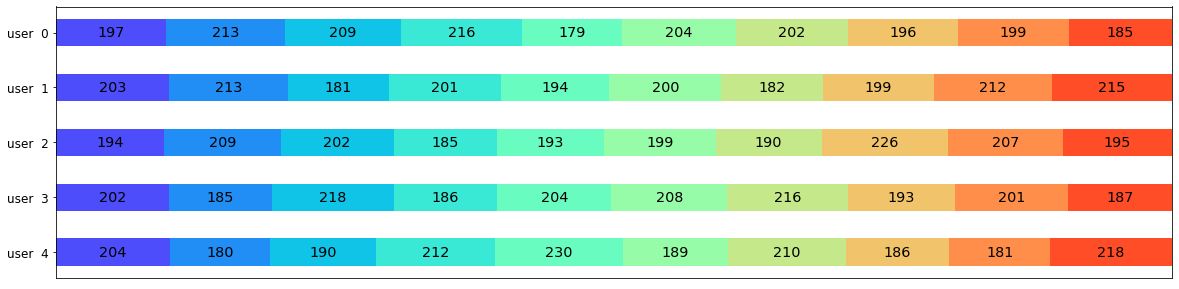

len shard = 1.0


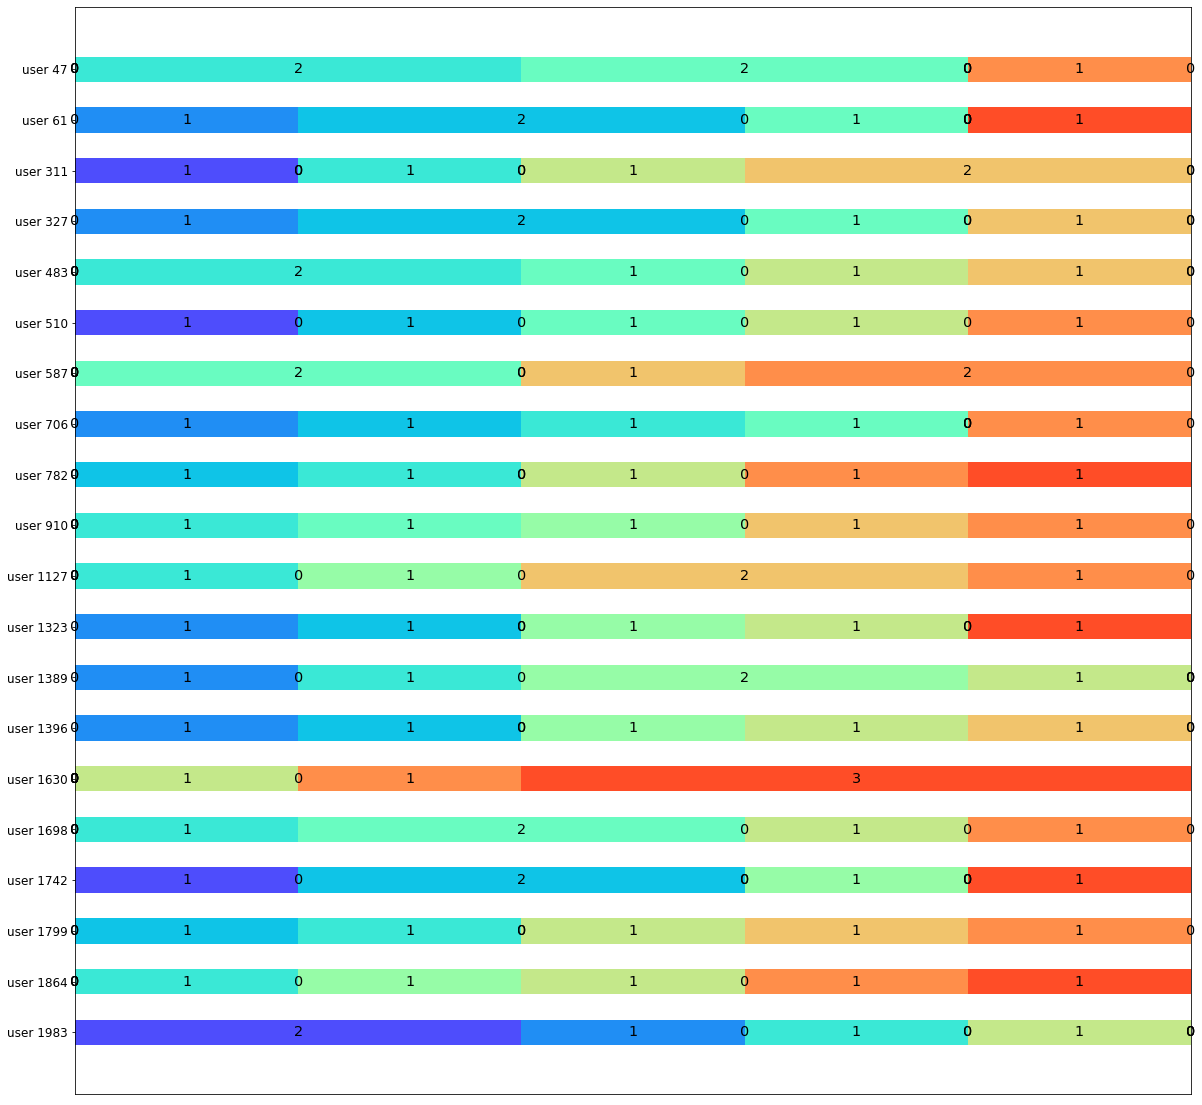

len shard = 71.42857142857143


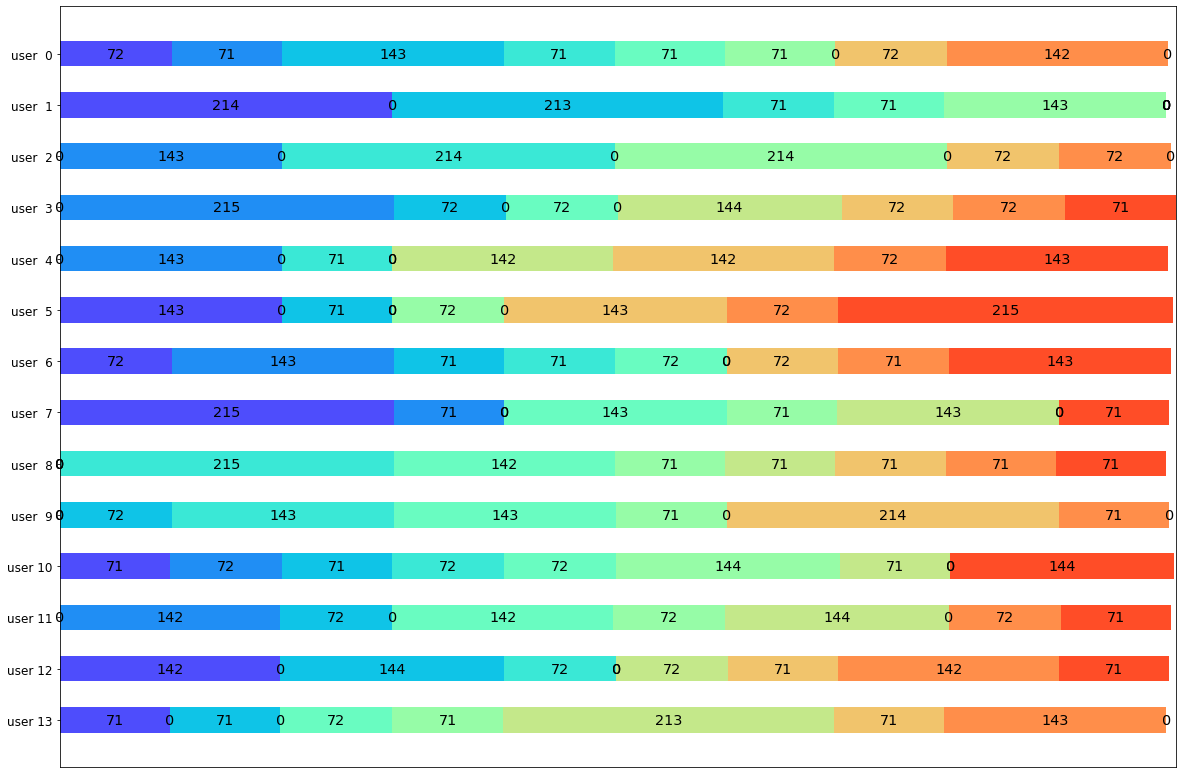

In [8]:
dataset = get_dataset("cifar10")

print(f'len shard = {len(dataset)/100/100}')
dict_users, rand_set_all, idxs_dict = noniid(dataset, num_users=100, shard_per_user=100, server_data_ratio=0.0, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

print(f'len shard = {len(dataset)/5/2000}')
dict_users, rand_set_all, idxs_dict = noniid(dataset, num_users=5, shard_per_user=2000, server_data_ratio=0.0, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=None, num_classes=None)

print(f'len shard = {len(dataset)/2000/5}')
dict_users, rand_set_all, idxs_dict = noniid(dataset, num_users=2000, shard_per_user=5, server_data_ratio=0.0, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

###

print(f'len shard = {len(dataset)/14/10}')
dict_users, rand_set_all, idxs_dict = noniid(dataset, num_users=14, shard_per_user=10, server_data_ratio=0.0, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=None, num_classes=None)


In [9]:
# mnist unbalance per classes
for k, v in sorted(idxs_dict.items()):
    l=[len(i) for i in v]
    print(f"label: {k}, num shard: {len(v)} -> {l} : {sum(l)}")
torch.tensor(dataset.targets).bincount()


label: 0, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 1, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 2, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 3, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 4, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 5, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 6, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 7, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 8, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000
label: 9, num shard: 14 -> [72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71] : 1000


tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

### noniid_replace
- 각 user에게 shard_per_user개의 서로 다른 class를 할당
- -> assert (num_classes > shard_per_user)
- -> 한 user는 각 class당 1개 이하의 shard를 가짐
- -> 한 user에게 할당되는 data 수 = 0 ~ class 수 * shard 길이
- -> 경우에 따라 한 class의 데이터보다 작거나 많은 양이 할당될 수 있음


In [10]:
dataset = get_dataset("cifar10")

## class 수보다 shard_per_user가 많으므로 -> ValueError: Cannot take a larger sample than population when 'replace=False'
print(f'len shard = {len(dataset)/5/2000}')
dict_users, rand_set_all = noniid_replace(dataset, num_users=5, shard_per_user=2000, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=None, num_classes=None)


Files already downloaded and verified
len shard = 1.0


ValueError: Cannot take a larger sample than population when 'replace=False'

len shard = 1.0


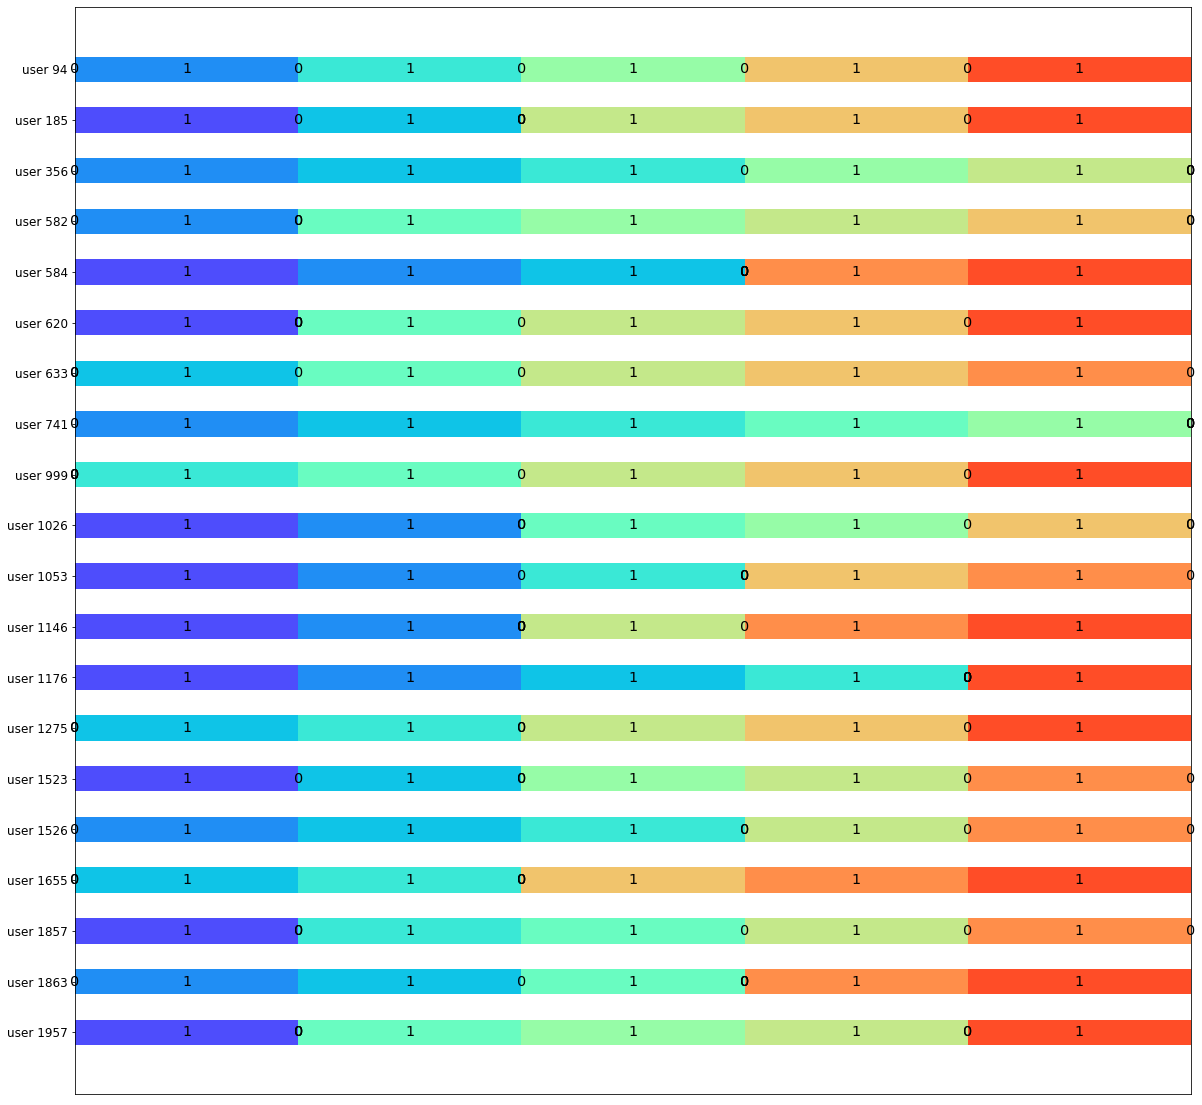

tensor([1018,  991, 1032,  991,  977, 1017, 1004, 1006,  979,  985])
10000 6287


In [ ]:
print(f'len shard = {len(dataset)/2000/5}')
dict_users, rand_set_all = noniid_replace(dataset, num_users=2000, shard_per_user=5, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

print(torch.tensor(np.array(rand_set_all)).reshape(-1).bincount())
# tensor([1030,  964,  979,  983,  975, 1007, 1013, 1021, 1001, 1027])
# class의 데이터보다 작거나 많은 양이 할당됨

idxes=np.concatenate(list(dict_users.values()))
print(len(idxes), len(np.unique(idxes)))
# => 데이터가 중복 할당됨


len shard = 50.0


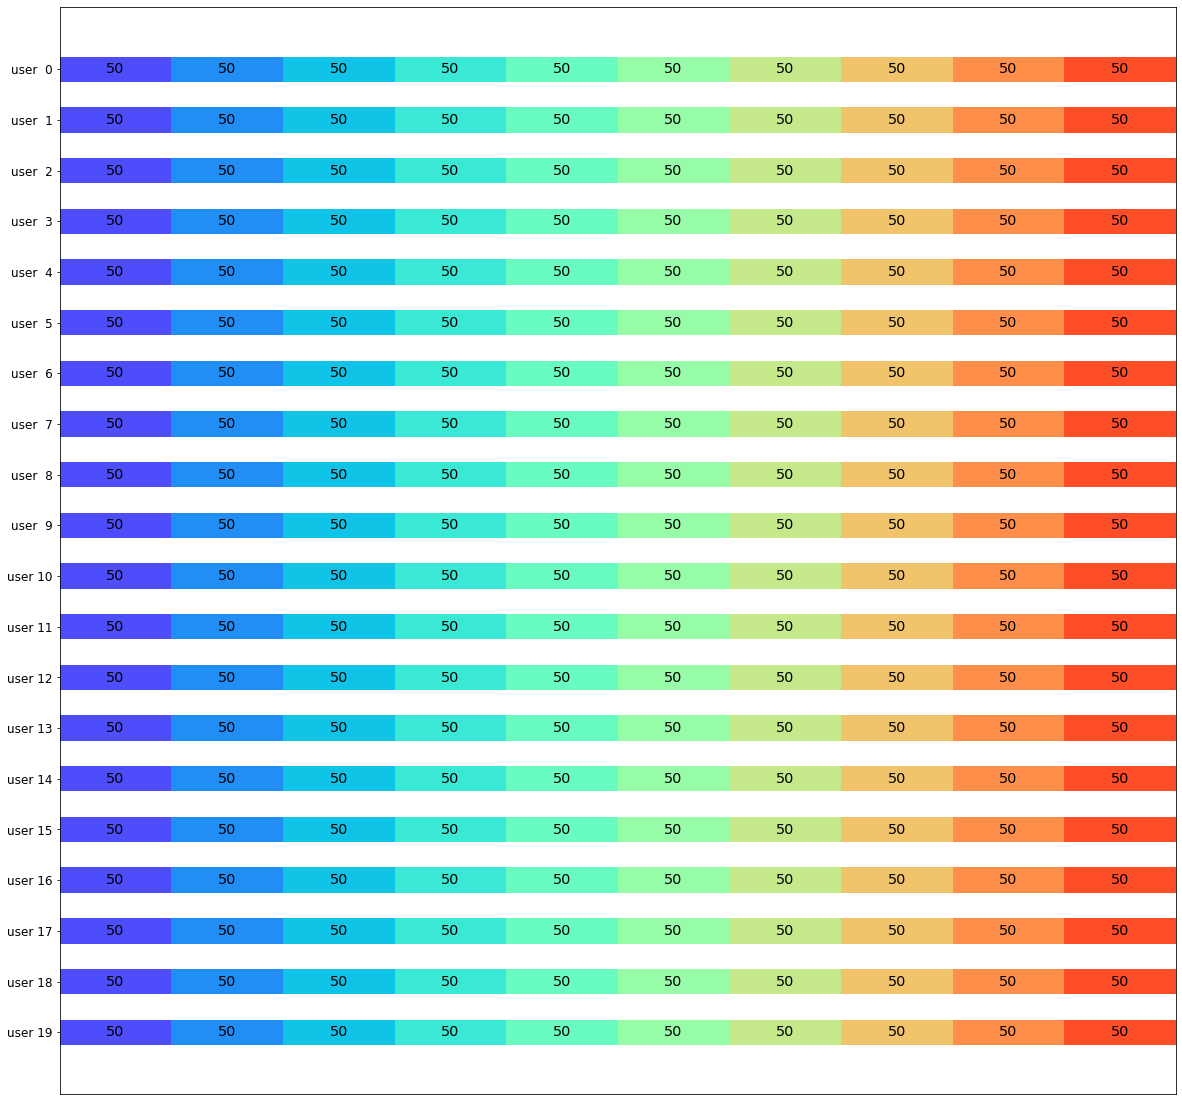

In [ ]:
print(f'len shard = {len(dataset)/20/10}')
dict_users, rand_set_all = noniid_replace(dataset, num_users=20, shard_per_user=10, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=None, num_classes=None)

len shard = 5.0


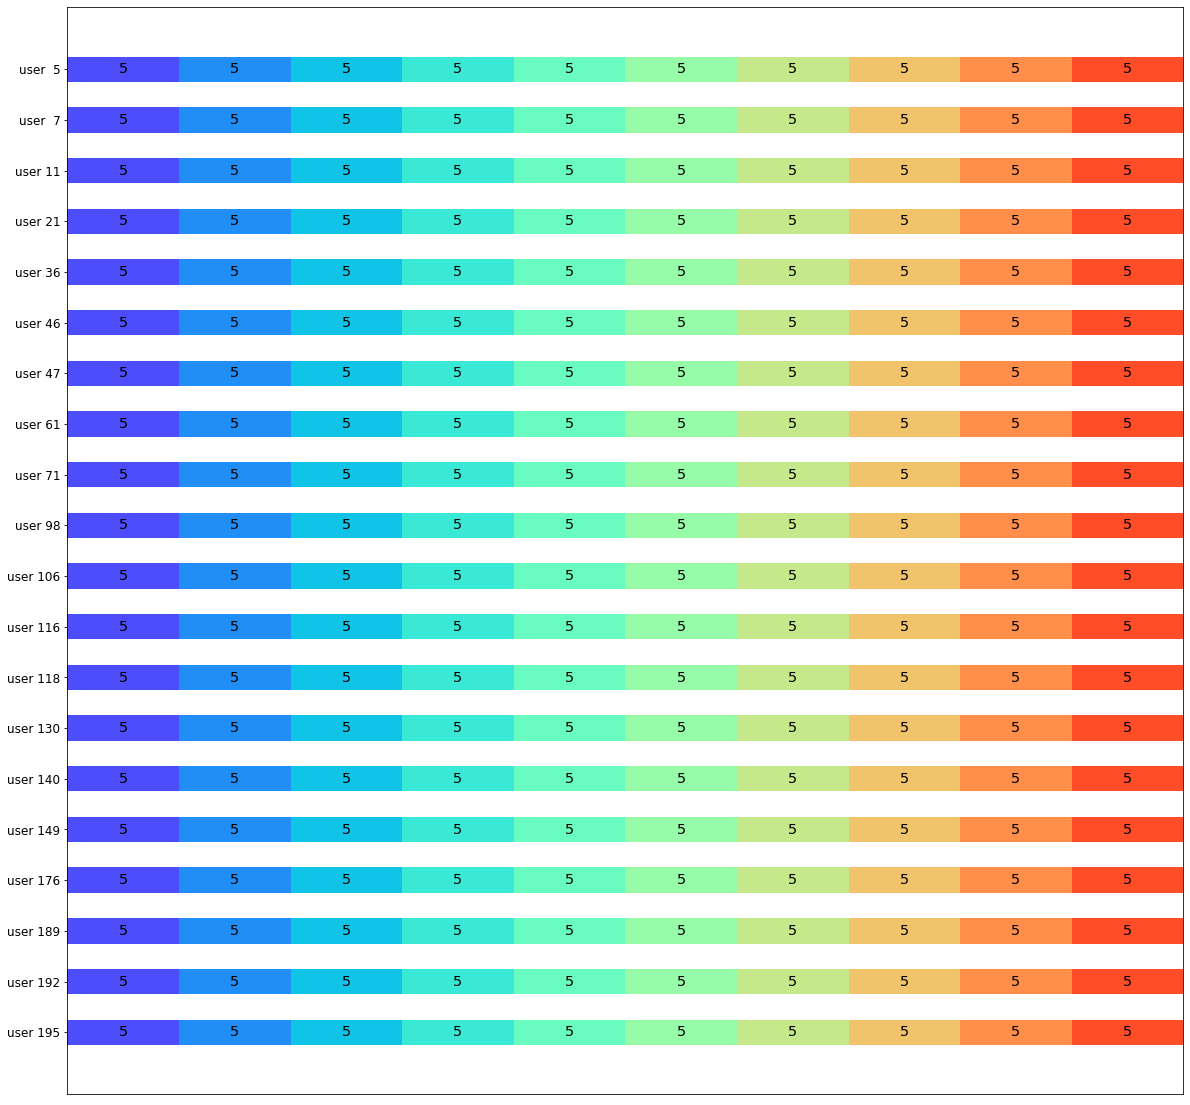

In [ ]:
print(f'len shard = {len(dataset)/200/10}')
dict_users, rand_set_all = noniid_replace(dataset, num_users=200, shard_per_user=10, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)
# data가 class 수 * shard 길이 만큼 할당됨

### iid_unbalanced
1. 유저를 반 나눔
2. 각각을 num_batch_users개의 batch로 나눔
3. 각 batch에서 moved_data_size*i를 빼고 그만큼 반대쪽에 더해줌
4. class에 무관하게 각 user에게 할당된 만큼 랜덤하게 뽑음
- 5로 나누는 이유 ??
- num_users = num_batch_users의 배수
- -> num_users//2 = num_batch_users의 배수이므로, num_users는 even (num_batch_users가 1이면 odd 가능)

Files already downloaded and verified
[151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]


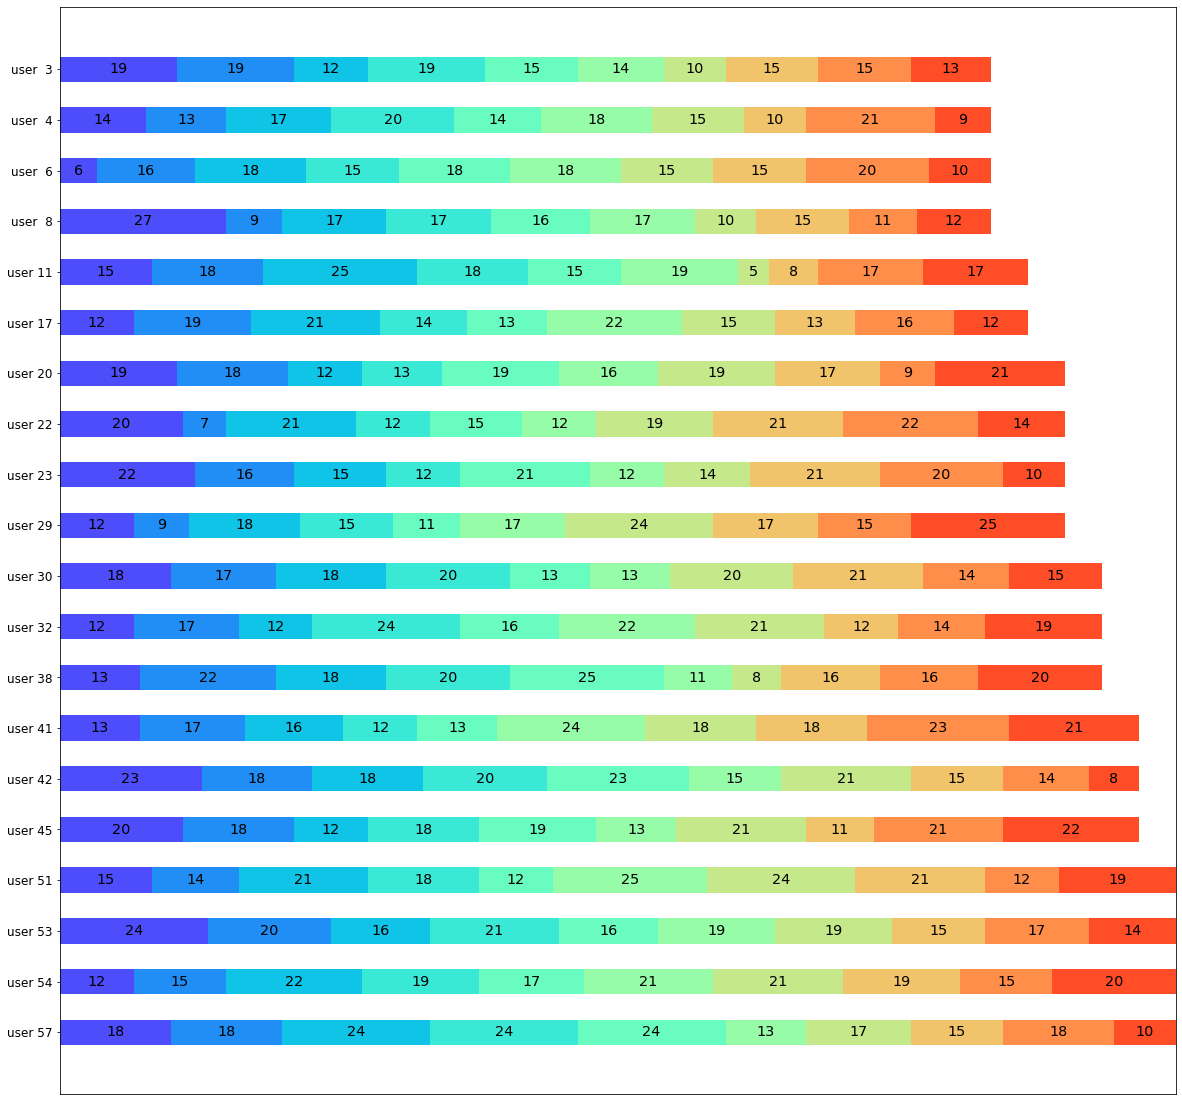

In [ ]:
dataset = get_dataset("cifar10")
dict_users = iid_unbalanced(dataset, num_users=60, num_batch_users=10, moved_data_size=30)
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190]


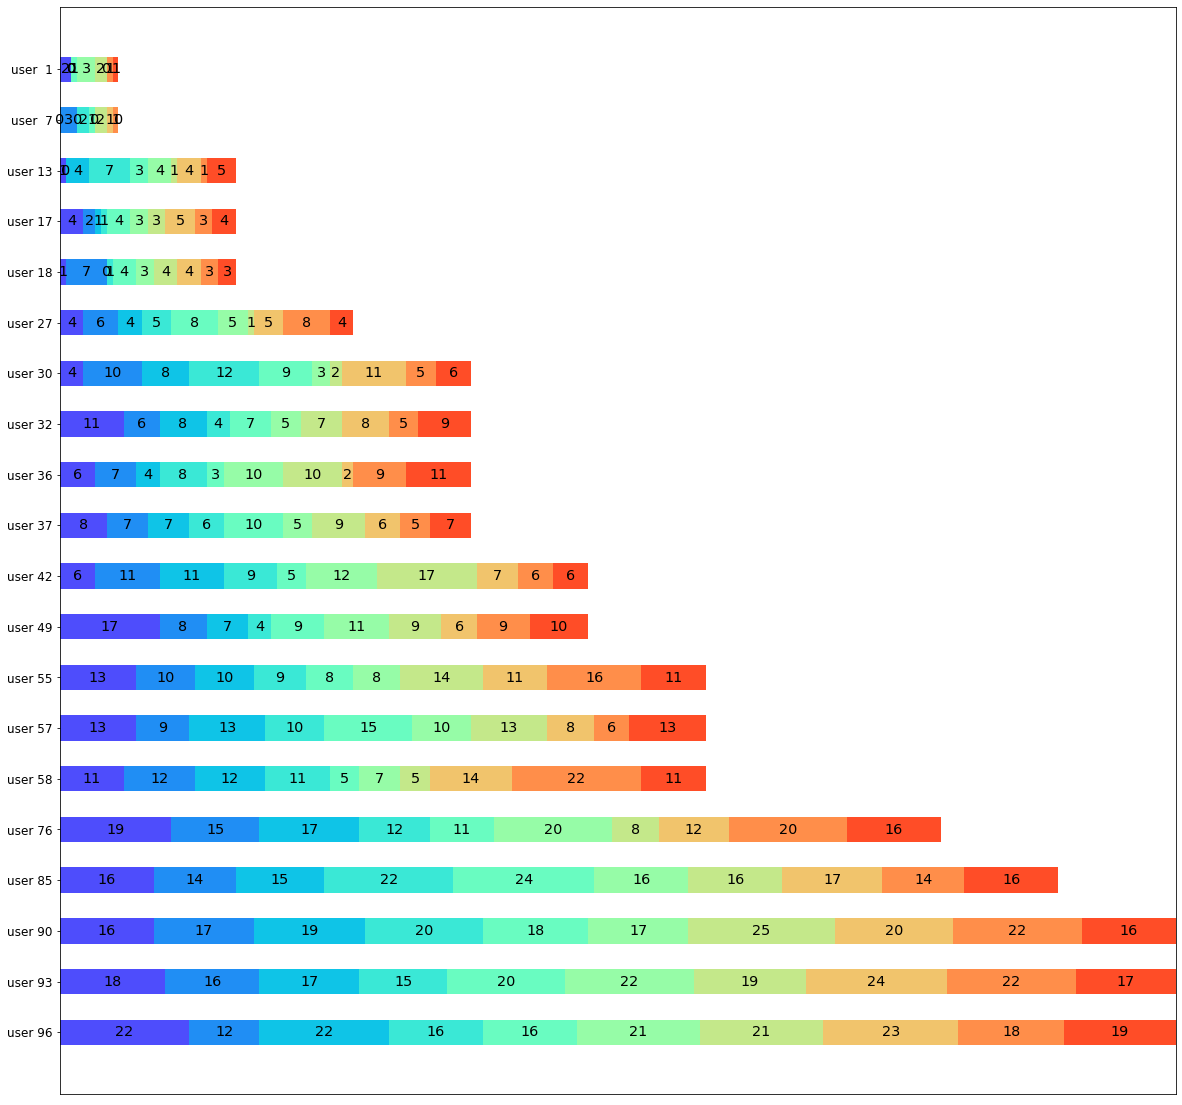

In [11]:
dict_users = iid_unbalanced(dataset, num_users=100, num_batch_users=10, moved_data_size=20*5)
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

Files already downloaded and verified
[276, 296, 316, 336, 356, 376, 396, 416, 436, 456, 476, 496, 516, 536, 556, 576, 596, 616, 636, 656, 676]


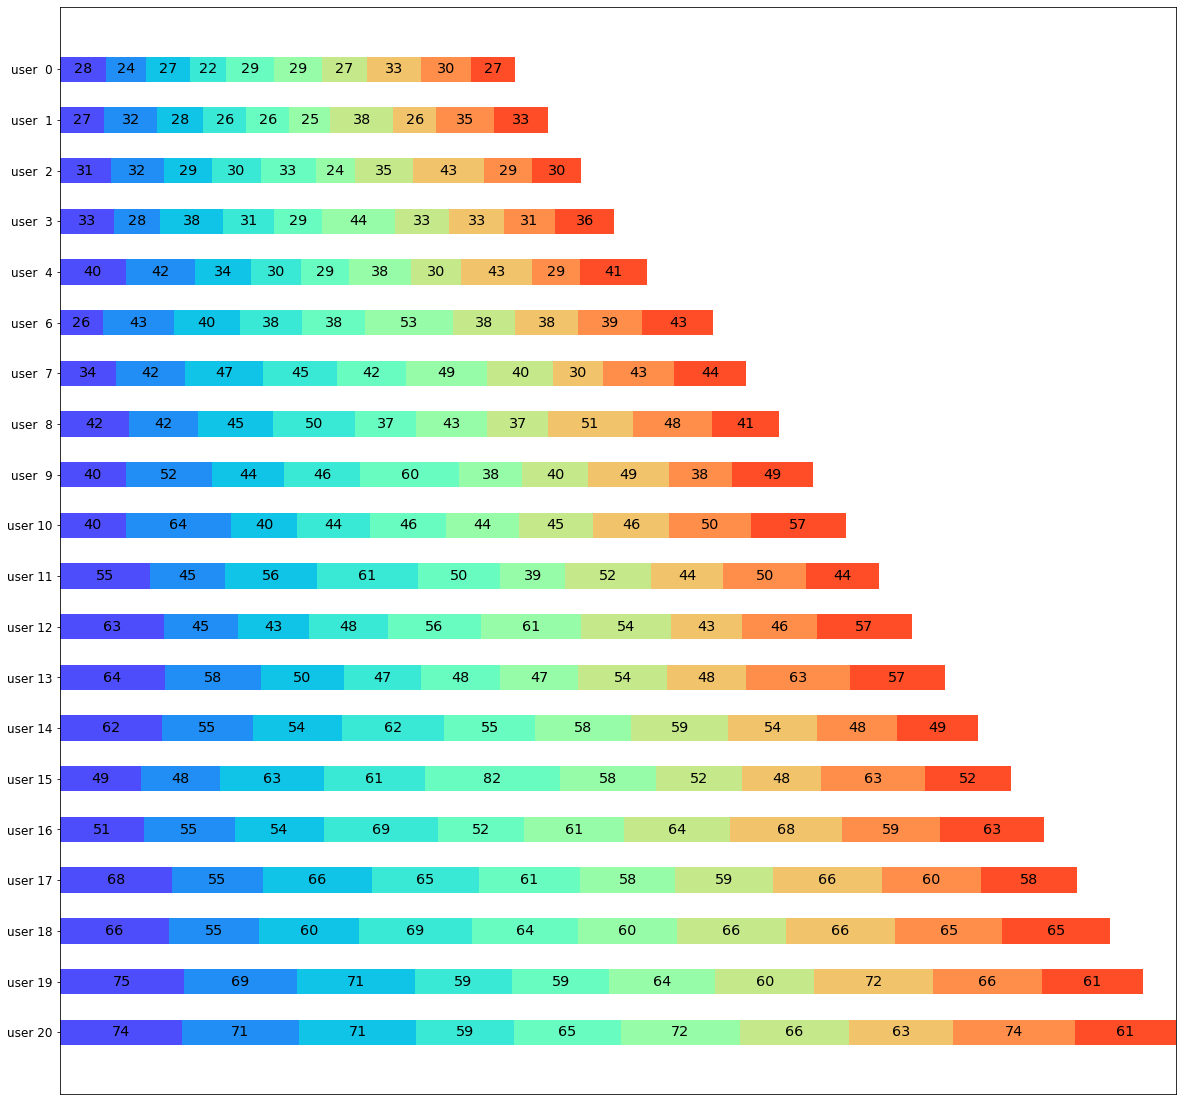

In [65]:
dataset = get_dataset("cifar10")
dict_users = iid_unbalanced(dataset, num_users=21, num_batch_users=1, moved_data_size=20*5)
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

### noniid_unbalanced
- iid_unbalanced를 shard로 한 것
- -> shard_per_user가 작을수록 class 불균형 & 데이터 수 불균형 높음
- 대응되는 user들끼리는 shard의 수와 shard들의 label이 동일함 => shard의 길이가 다름
- num_users가 odd면 중간은 쌍이 없기 때문에 data가 할당 안됨

Files already downloaded and verified
[151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Remain datas(idxs) (idxs_dict): 4000


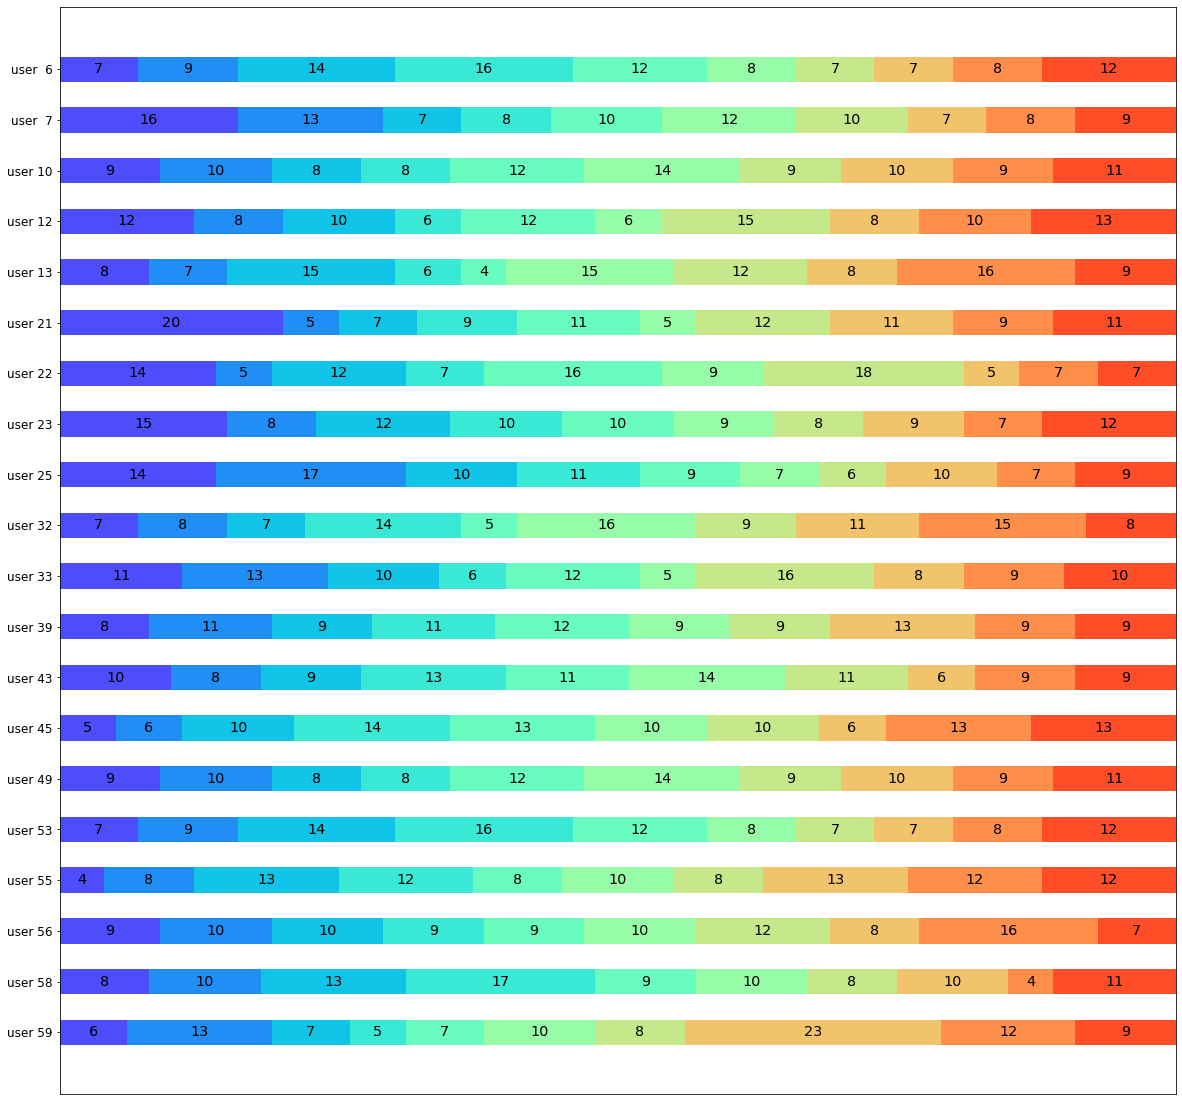

In [91]:
dataset = get_dataset("cifar10")
dict_users, rand_set_all = noniid_unbalanced(dataset, num_users=60, num_batch_users=10, moved_data_size=6*5, shard_per_user=100, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

[151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Remain datas(idxs) (idxs_dict): 150


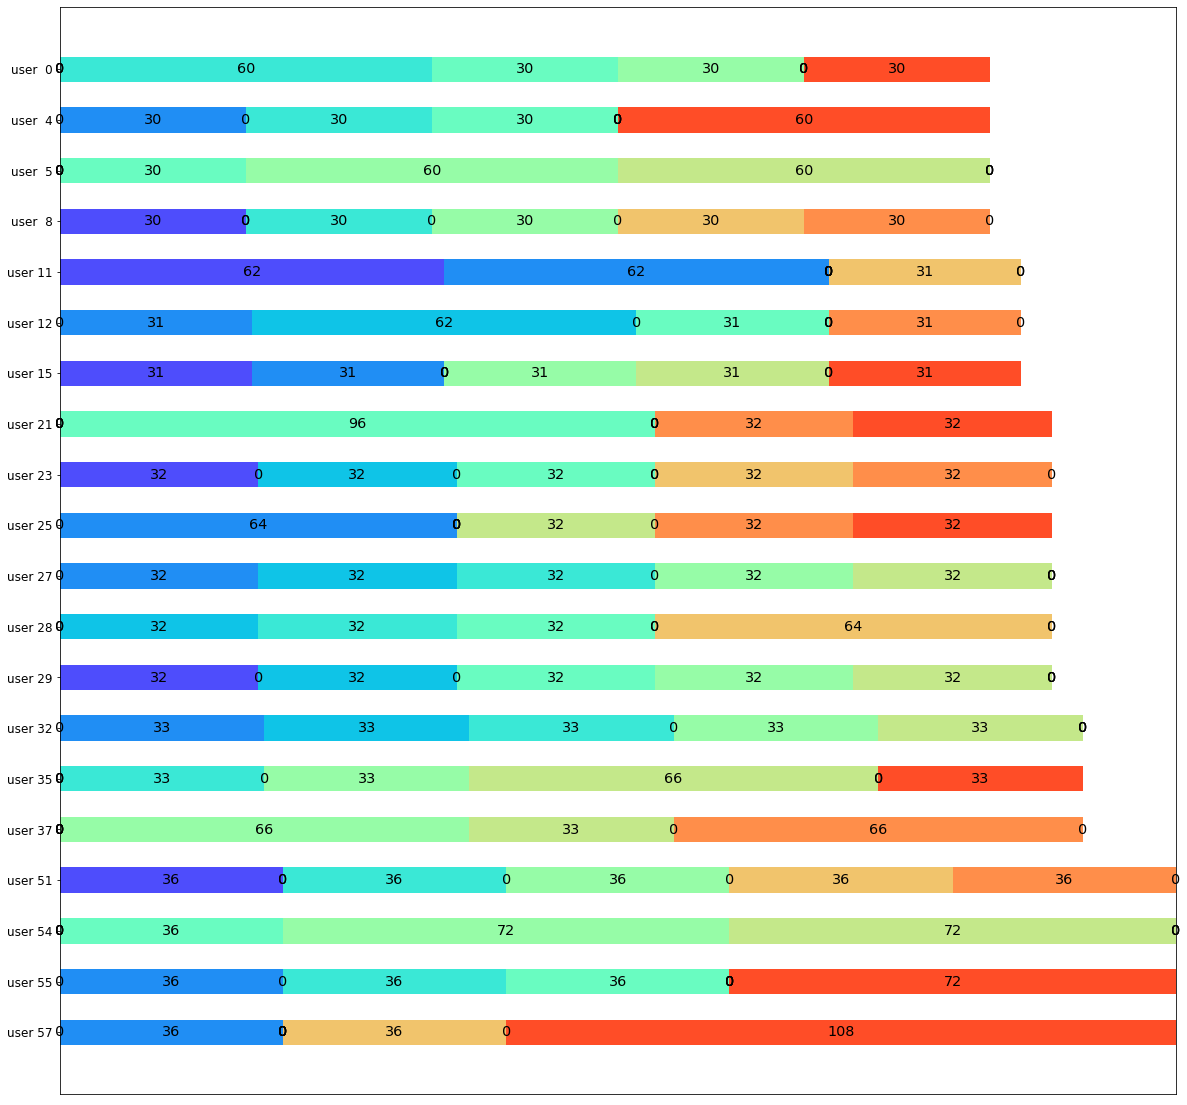

In [93]:
dict_users, rand_set_all = noniid_unbalanced(dataset, num_users=60, num_batch_users=10, moved_data_size=6*5, shard_per_user=5, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)

Files already downloaded and verified
[276, 296, 316, 336, 356, 376, 396, 416, 436, 456, 476, 496, 516, 536, 556, 576, 596, 616, 636, 656, 676]
Remain datas(idxs) (idxs_dict): 600


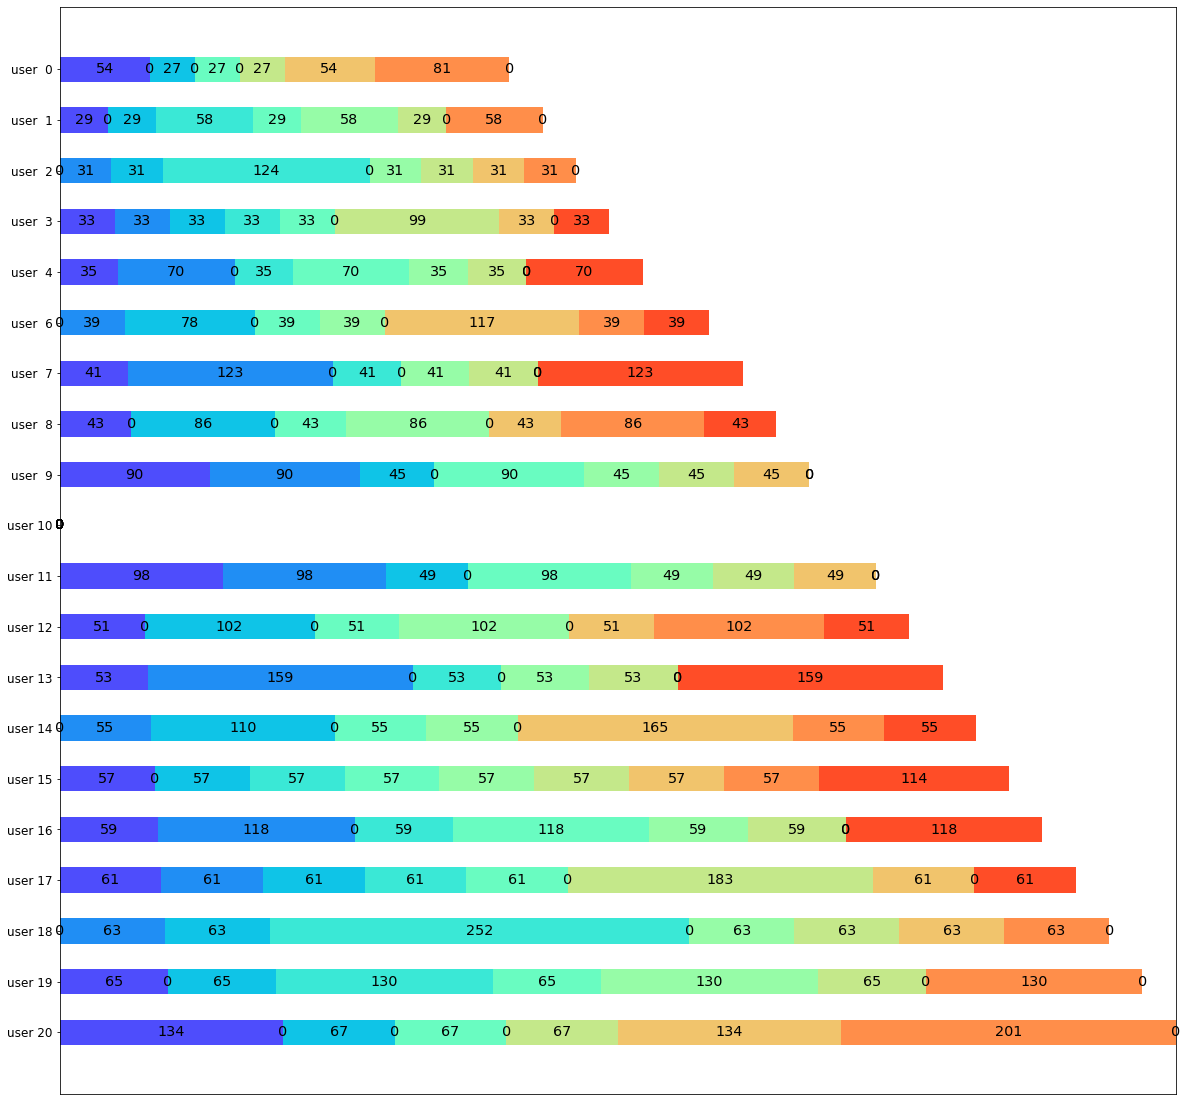

In [87]:
dataset = get_dataset("cifar10")
dict_users, rand_set_all = noniid_unbalanced(dataset, num_users=21, num_batch_users=1, moved_data_size=20*5, shard_per_user=10, rand_set_all=[])
plot(dataset, dict_users, show_label=True, num_users=20, num_classes=None)